In [164]:
import json
import pandas as pd
import numpy as np
from markovclick.models import MarkovClickstream
from markovclick.viz import visualise_markov_chain
from pycspade.helpers import spade, print_result
import matplotlib.pyplot as plt
import seaborn as sns

In [69]:

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

# Reading Dataset

In [18]:
with open('dataset.json', 'r') as f:
    dataset = pd.DataFrame([json.loads(i) for i in f.readlines()])
dataset.head()

,action,timestamp,step,user
0,copy_exp_code,1.560819e+12,1,1
1,copy_exp_code,1.560819e+12,1,1
2,copy_exp_code,1.560819e+12,1,1
3,copy_exp_code,1.560819e+12,1,1
4,copy_exp_code,1.560820e+12,1,1


In [20]:
action_user = dataset.drop_duplicates(subset=['action', 'step', 'user'], keep='first', inplace=False)
action_user.head()

,action,timestamp,step,user
0,copy_exp_code,1.560819e+12,1,1
22,copy_exp_output,1.560820e+12,1,1
23,copy_google,1.560819e+12,1,1
29,copy_left,1.560820e+12,1,1
31,ipynb_layout_(add_box),1.560819e+12,1,1


In [76]:
user_action = action_user[['action', 'step', 'user']]
user_action = user_action.groupby(by=['user', 'step'])['action'].apply(list).reset_index(name='actions')
user_action.head()

,user,step,actions
0,1,1,"[copy_exp_code, copy_exp_output, copy_google, ..."
1,1,2,"[copy_exp_code, ipynb_layout_(add_box), ipynb_..."
2,1,3,"[copy_exp_code, copy_exp_output, copy_google, ..."
3,1,4,"[copy_exp_code, copy_exp_output, copy_google, ..."
4,1,5,"[copy_exp_code, copy_exp_output, copy_google, ..."


# Actions Distribution

In [52]:
action_user.action.value_counts()

leave_right_aoi              195
leave_middle_aoi             195
leave_left_aoi               190
scrollbar_M_forward          187
ipynb_layout_(write_code)    187
scrollbar_M_back             186
ipynb_layout_(add_box)       179
tab_exp                      172
tab_other                    170
scrollbar_L_forward          157
scrollbar_R_back             152
scrollbar_R_forward          152
scrollbar_L_back             148
copy_exp_code                139
tag_add_by_panel             128
scrollbar_X                  127
copy_left                    125
copy_google                  124
click_on_code_by_1           115
left_button_copy              82
tab_pra                       69
tag_add_by_click              63
copy_exp_output               60
tag_remove_by_click           48
tag_remove_by_panel           48
copy_pra_code                 18
resize_browser                 8
click_on_code_by_3             7
Name: action, dtype: int64

<AxesSubplot:>

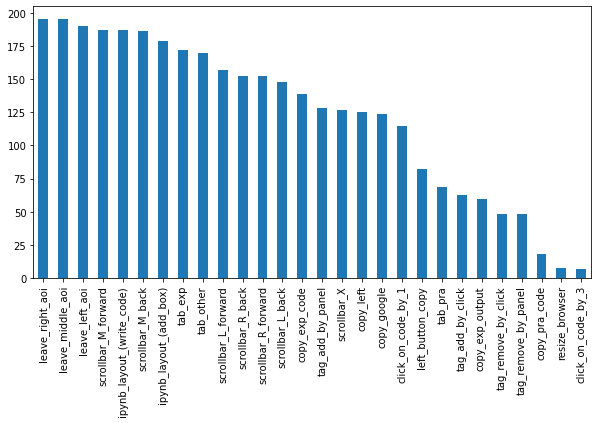

In [67]:
action_user.action.value_counts().plot.bar()

<AxesSubplot:ylabel='action'>

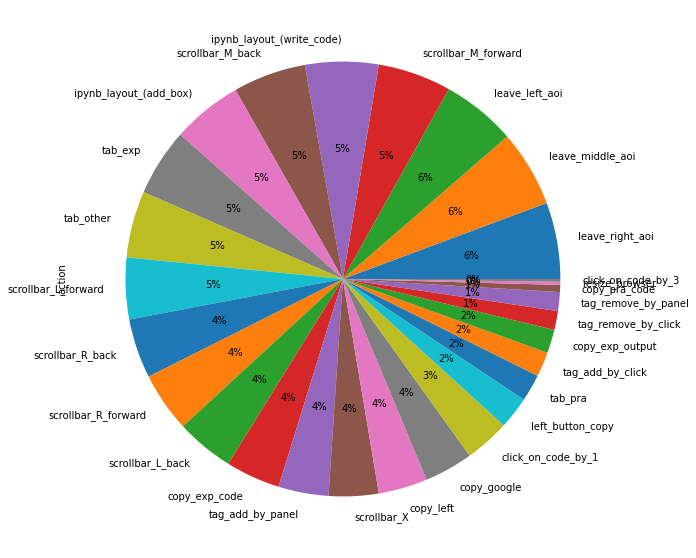

In [75]:
action_user.action.value_counts().plot.pie(autopct='%1.0f%%', labeldistance=1.1)

As you can see in the picture, 5% of all actions are related to external search and it is also considered as one of the actions with a large number of accomplishments


## External Search Distribution


In [121]:
users = list(action_user.user.unique())
high_performance_users = [2, 3, 6, 8, 9, 11, 14, 42, 46, 50, 58]
low_performance_users = [1, 4, 5, 7, 10, 13, 16, 19, 20, 25, 27, 28, 29, 30, 31,
                         32, 33, 34, 37, 39, 40, 41, 43, 45, 47, 49, 51, 52,]

In [122]:
external_search = action_user[action_user.action == 'tab_other']
print('Average user clicks on external search (count): ', external_search.user.value_counts().mean())

Average user clicks on external search (count):  4.358974358974359


In [123]:
users_click_external_rate = {i:external_search[external_search.user == i].shape[0]/action_user[action_user.user == i].shape[0] for i in users}

print('Average user clicks on external search (rate): ', np.mean(list(users_click_external_rate.values())))
print('Variance user clicks on external search (rate): ', np.var(list(users_click_external_rate.values())))

Average user clicks on external search (rate):  0.049554880074485365
Variance user clicks on external search (rate):  0.00012948434590396898


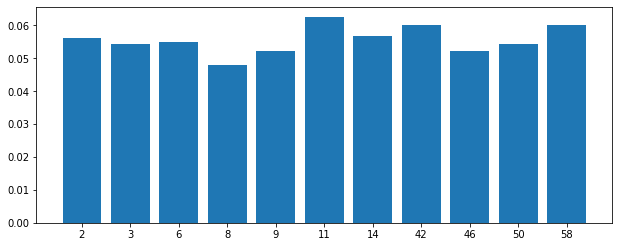

Average of high-performance users clicks on external search:  0.05562401651568016
Variance of high-performance users clicks on external search:  1.612693272102756e-05


In [189]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.rcParams["figure.figsize"] = [8, 3]
ax.bar([str(i) for i in high_performance_users],[users_click_external_rate[i] for i in high_performance_users])
plt.show()
print('Average of high-performance users clicks on external search: ', np.mean([users_click_external_rate[i] for i in high_performance_users]))
print('Variance of high-performance users clicks on external search: ', np.var([users_click_external_rate[i] for i in high_performance_users]))

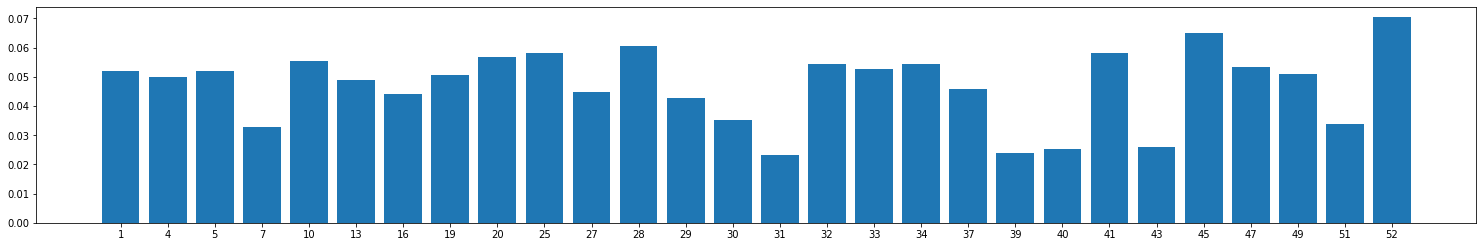

Average of low-performance users clicks on external search:  0.04717057647258739
Variance of low-performance users clicks on external search:  0.0001538620478255215


In [191]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.rcParams["figure.figsize"] = [20, 3]
ax.bar([str(i) for i in low_performance_users],[users_click_external_rate[i] for i in low_performance_users])
plt.show()
print('Average of low-performance users clicks on external search: ', np.mean([users_click_external_rate[i] for i in low_performance_users]))
print('Variance of low-performance users clicks on external search: ', np.var([users_click_external_rate[i] for i in low_performance_users]))

In this section, we compare the average click of each user on external search. The variance of clicking on external search is one hundred percent in all users, but in high-performance users this variance is less and these people behave similarly when clicking on external search. But to some extent, people with high performance have clicked on this external search more than people with less performance.


## Using Markov Model
In this section, we want to check the order of actions and for this purpose, we use the Markov model and drawing the state machine.

In [137]:
user_action['id'] = user_action.apply(lambda x: str(x.user)+'_'+str(x.step), axis=1)
user_action['len'] = user_action.actions.apply(lambda x: len(x))
max_len = user_action.len.max()
user_action.head()

,user,step,actions,id,len
0,1,1,"[copy_exp_code, copy_exp_output, copy_google, ...",1_1,18
1,1,2,"[copy_exp_code, ipynb_layout_(add_box), ipynb_...",1_2,17
2,1,3,"[copy_exp_code, copy_exp_output, copy_google, ...",1_3,23
3,1,4,"[copy_exp_code, copy_exp_output, copy_google, ...",1_4,19
4,1,5,"[copy_exp_code, copy_exp_output, copy_google, ...",1_5,19


In [161]:
user_action_table = [[row.actions[j] for j in range(max_len) if j < len(row.actions) ] for i, row in user_action.iterrows()]
user_action_table[0]

['copy_exp_code',
 'copy_exp_output',
 'copy_google',
 'copy_left',
 'ipynb_layout_(add_box)',
 'ipynb_layout_(write_code)',
 'leave_left_aoi',
 'leave_middle_aoi',
 'leave_right_aoi',
 'scrollbar_L_back',
 'scrollbar_L_forward',
 'scrollbar_M_back',
 'scrollbar_M_forward',
 'scrollbar_R_back',
 'scrollbar_R_forward',
 'tab_exp',
 'tab_other',
 'tab_pra']

<AxesSubplot:>

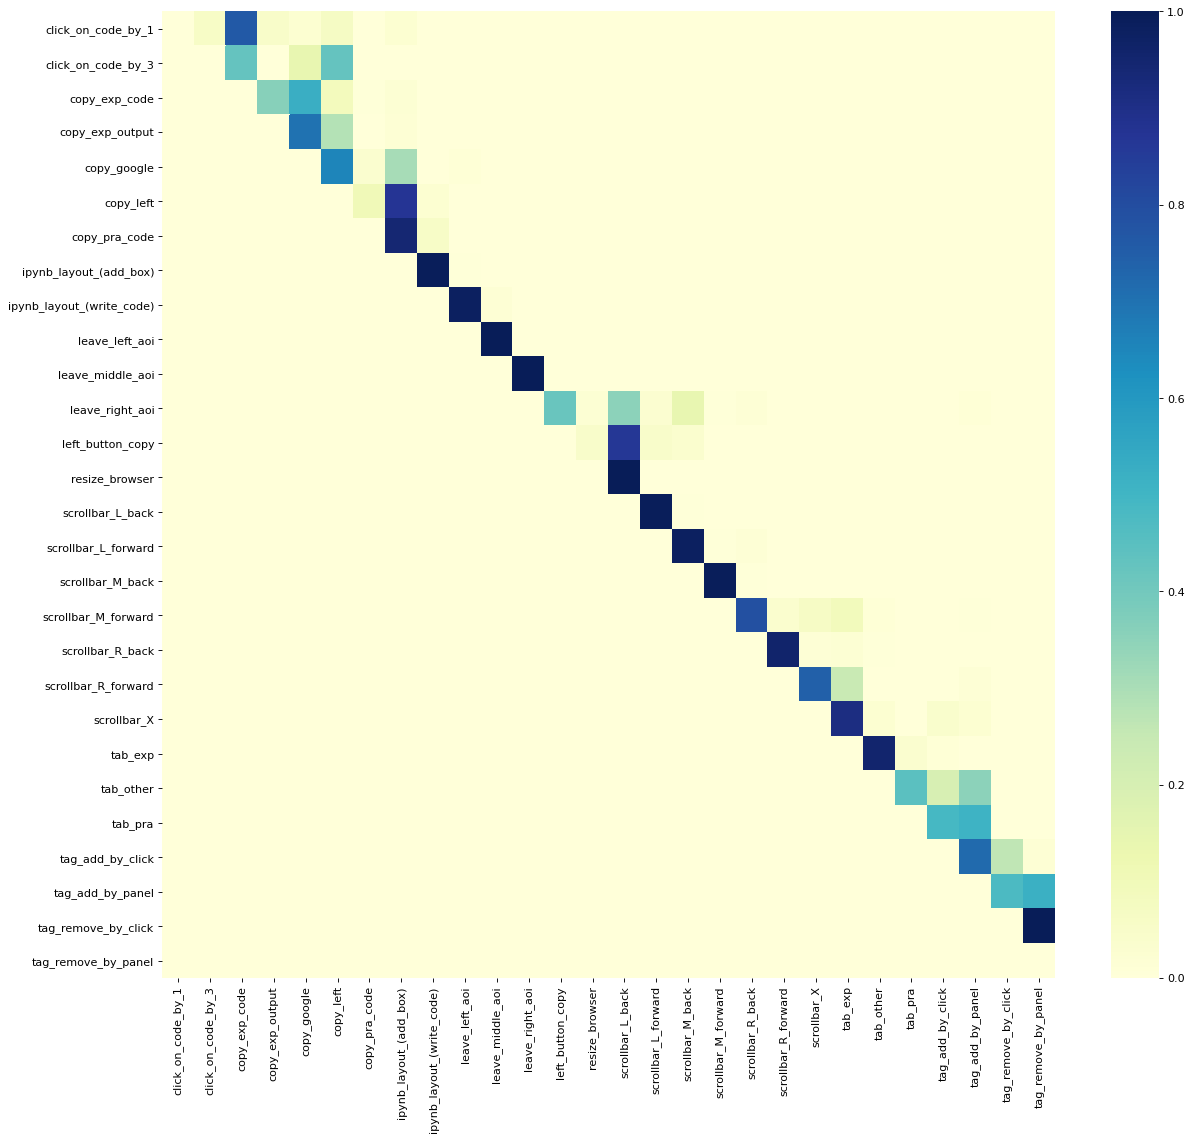

In [187]:

m = MarkovClickstream(user_action_table)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(m.prob_matrix, xticklabels=m.pages, yticklabels=m.pages,cmap="YlGnBu", annot=False)

A heat map is a useful tool for representing the transition probability matrix. The Y-axis represents the current state (From) and the X-axis represents the next state (To). You can see the utility in the heat map above, where the darker blue represents a higher probability of transition.


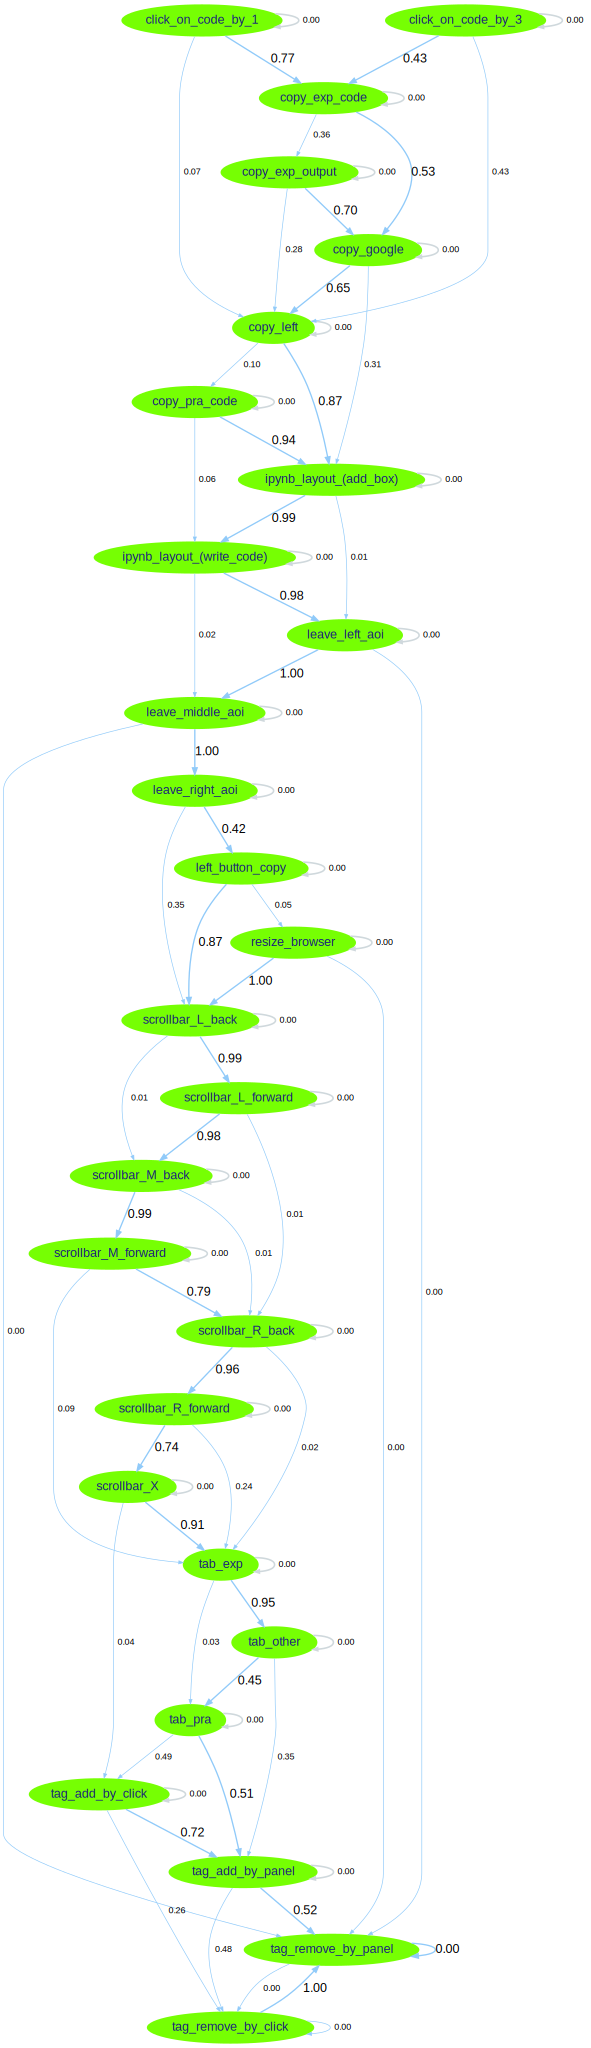

In [160]:
graph = visualise_markov_chain(m)
graph


A Markov Chain is a Markov process that describes the sequence of possible events, in which the probability of each event is dependent on the state attained in the previous event. It can be graphically represented as a transition diagram along with the corresponding probabilities.


As you can see, the external search is more likely to be done after changing the tab, and changing the tab is also more likely after scrolling. This indicates that users are more likely to work in this way: first they code, then Google, and then look for the reason (probably for the problem they encountered) in their own code, and then turn to external search.

### Finding most sequences of action with high probability

In this section, I wanted to find the sequence of actions that most likely occur, and I wanted to use the Spade algorithm. But at the moment I could not use this library and it gives an error :(

In [183]:
result = spade(data=user_action[['user', 'step', 'actions']].values.tolist(), support=0.01)
print_result(result)

RuntimeError: Error reading item

In [180]:
s = ''
for i in user_action[['user', 'step', 'len', 'actions']].values.tolist():
    actions_list = " ".join(i[-1])
    s += ' '.join([str(j) for j in i[:3]])
    s += ' ' + actions_list + '\n'
with open('actions_list.txt', 'w') as f:
    f.write(s)

In [182]:
result = spade(filename='actions_list.txt', support=0.3, parse=False)
print(result['mined'])

RuntimeError: Error reading item